In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from IPython.display import Image
import scipy.stats as stats

from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

%matplotlib inline

In [2]:
data = pd.read_csv('../data/so.csv')

In [3]:
data = data[data.gender.isin(['Male', 'Female', 'Other'])]

In [4]:
data.gender.value_counts()

Male      51388
Female     3202
Other       274
Name: gender, dtype: int64

In [5]:
data.dogs_vs_cats.value_counts()

Dogs                      21852
Cats                      15508
Other (please specify)     7218
Name: dogs_vs_cats, dtype: int64

In [6]:
data.columns

Index(['Unnamed: 0', 'collector', 'country', 'un_subregion', 'so_region',
       'age_range', 'age_midpoint', 'gender', 'self_identification',
       'occupation', 'occupation_group', 'experience_range',
       'experience_midpoint', 'salary_range', 'salary_midpoint',
       'big_mac_index', 'tech_do', 'tech_want', 'aliens',
       'programming_ability', 'employment_status', 'industry',
       'company_size_range', 'team_size_range', 'women_on_team', 'remote',
       'job_satisfaction', 'job_discovery', 'dev_environment',
       'commit_frequency', 'hobby', 'dogs_vs_cats', 'desktop_os',
       'unit_testing', 'rep_range', 'visit_frequency', 'why_learn_new_tech',
       'education', 'open_to_new_job', 'new_job_value', 'job_search_annoyance',
       'interview_likelihood', 'how_to_improve_interview_process',
       'star_wars_vs_star_trek', 'agree_tech', 'agree_notice',
       'agree_problemsolving', 'agree_diversity', 'agree_adblocker',
       'agree_alcohol', 'agree_loveboss', 'agree_n

In [7]:
def df_to_cpd(df, target_var, parents=[],):
    variable_cardinality = df[target_var].nunique()
    if len(parents) == 0:
        values = [df[target_var].value_counts(normalize=True).values]
    else:
        df = df.dropna(subset=[target_var]+parents)
        evidence_card = [df[c].nunique() for c in parents]
        evidence = 1 #todo

In [8]:
model = BayesianModel([('gender', 'dogs_vs_cats'), ('age_midpoint', 'dogs_vs_cats')])
model.fit(data, estimator_type=MaximumLikelihoodEstimator, complete_samples_only=False)
infer = VariableElimination(model)
df = data

def ev(dictionary):
    return {k: list(df[k].unique()).index(v) for k,v in dictionary.items()}


In [9]:
print(infer.query(['dogs_vs_cats'], evidence=ev({'gender':'Male'}))['dogs_vs_cats'])

╒════════════════╤═════════════════════╕
│ dogs_vs_cats   │   phi(dogs_vs_cats) │
╞════════════════╪═════════════════════╡
│ dogs_vs_cats_0 │              0.3924 │
├────────────────┼─────────────────────┤
│ dogs_vs_cats_1 │              0.4143 │
├────────────────┼─────────────────────┤
│ dogs_vs_cats_2 │              0.1933 │
╘════════════════╧═════════════════════╛


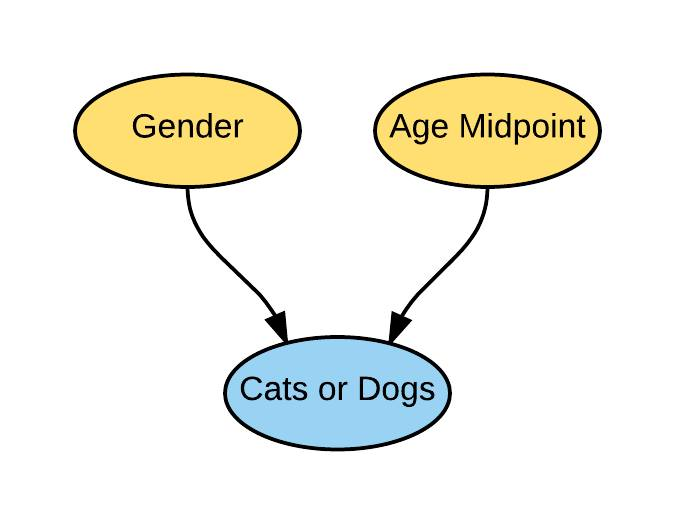

In [10]:
Image('../figures/catdog.png')

Picca voor *M. Bueno*

In [25]:
df_ = df.dropna(subset=['salary_range'])
df_ = df_[df_['salary_range'].str.contains('\$')]
df_['desktop_os'] = df_['desktop_os'].str.replace('Ubuntu|Debian|Fedora|Mint|Other Linux', 'Linux')
df_['desktop_os'] = df_['desktop_os'].str.replace('Windows.*', 'Windows')
df_['is_javascript'] = df_['tech_do'].str.contains('JavaScript')
df_['is_php'] = df_['tech_do'].str.contains('PHP')
df_['is_python'] = df_['tech_do'].str.contains('Python')
df_['salary_range'] = df_.salary_range.str.replace('\$[0-9]{3},000 - \$[0-9]{3},000', 'More than $100,000')
df_['salary_range'] = df_.salary_range.str.replace('More than \$200,000', 'More than $100,000')

In [26]:
model = BayesianModel([('age_range', 'star_wars_vs_star_trek'), 
                       ('age_range', 'experience_range'),
                       ('experience_range', 'salary_range'),
                       ('gender', 'salary_range'),
                       ('un_subregion', 'salary_range'),
                       ('gender', 'agree_diversity'),
                       ('agree_diversity', 'is_javascript'),
                       ('agree_diversity', 'is_php'),
                       ('agree_diversity', 'is_python'),
                       ('un_subregion', 'desktop_os'),
                       ('desktop_os', 'is_javascript'),
                       ('desktop_os', 'is_php'),
                       ('desktop_os', 'is_python'),
                       ('is_javascript', 'salary_range'),
                       ('is_php', 'salary_range'),
                       ('is_python', 'salary_range'),
                       ('age_range', 'desktop_os'),
                       ('un_subregion', 'agree_diversity'),])
model.fit(df_, estimator_type=MaximumLikelihoodEstimator, complete_samples_only=False)

In [28]:
with open('cpds.txt', 'w', encoding='utf-8') as out:
    for cpd in model.get_cpds():
        out.write(str(cpd) + '\n')

In [ ]:
df_['salary_range']

In [ ]:
Image('../figures/network1.png')

In [29]:
data = df_[['age_range', 'star_wars_vs_star_trek', 'experience_range', 
            'salary_range', 'gender', 'un_subregion', 'agree_diversity',
            'is_javascript', 'is_php', 'is_python', 'desktop_os', 'age_midpoint', 
            'salary_midpoint', 'experience_midpoint']]

In [ ]:
likert = ['Disagree completely', 'Disagree somewhat', 'Neutral', 'Agree somewhat', 'Agree completely']
data['agree_diversity'] = data['agree_diversity'].apply(lambda x: likert.index(x) + 1 if x in likert else np.nan)
print(data['agree_diversity'].head())

In [14]:
sb.set(font_scale=1.5)
def correlation(data, x, y, xname, yname):
    d = data.dropna(subset=[x, y])
    print('correlation {} with {}'.format(x, y))
    print('r=%.2f, p=%.20f' % stats.pearsonr(d[x], d[y]))
    plt.figure(figsize=(10, 10))
    
    
    font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
    
    ax = sb.violinplot(d[x], d[y], xlabel=xname)
    ax.set(xlabel=xname, ylabel=yname)
    
    plt.show()

correlation age_midpoint with experience_midpoint
r=0.68, p=0.00000000000000000000


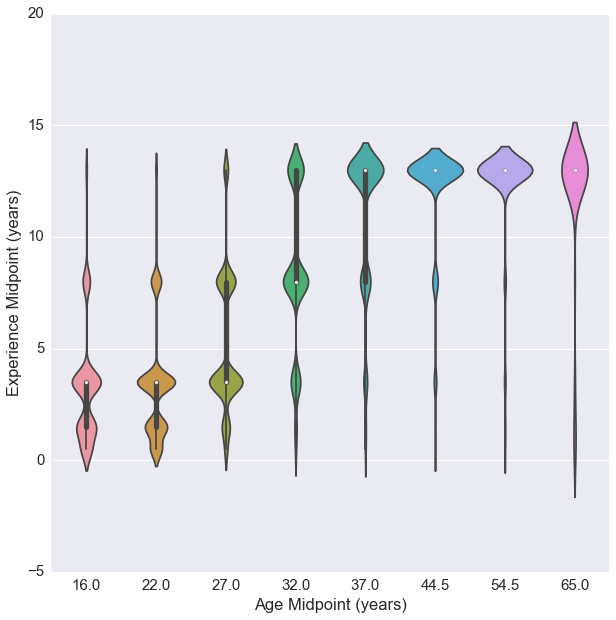

correlation experience_midpoint with salary_midpoint
r=0.49, p=0.00000000000000000000


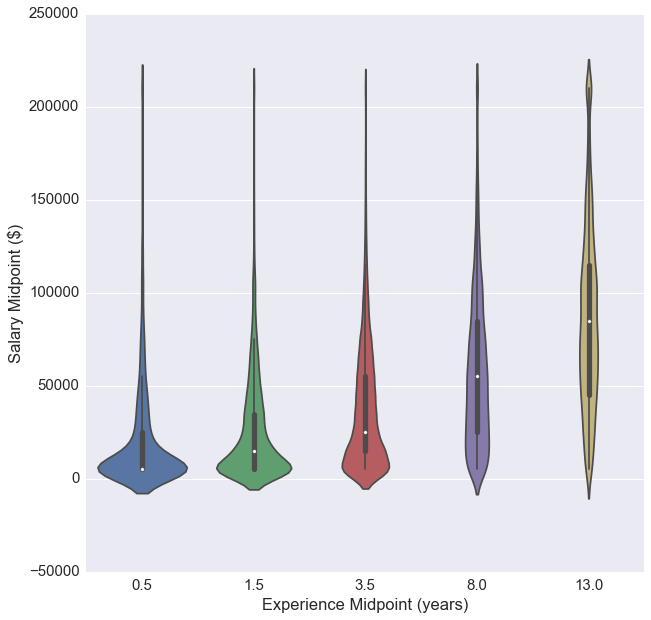

In [15]:
correlation(data, 'age_midpoint', 'experience_midpoint', 'Age Midpoint (years)', 'Experience Midpoint (years)')
correlation(data, 'experience_midpoint', 'salary_midpoint', 'Experience Midpoint (years)', 'Salary Midpoint ($)')

In [33]:
stats.ttest_ind(data.age_midpoint[data.star_wars_vs_star_trek == 'Star Wars'].dropna(), data.age_midpoint[data.star_wars_vs_star_trek == 'Star Trek'].dropna())

Ttest_indResult(statistic=-38.465081646314331, pvalue=0.0)

In [17]:
def test_median(data, x, y, normal=True, plots=False):
    d = data.dropna(subset=[x, y])
    groups = [d[y][d[x] == u] for u in d[x].unique()]
    if plots:
        for group in groups:
            plt.figure()
            plt.hist(group)
            plt.show()
    if normal:
        F, p = stats.f_oneway(*groups)
    else:
        F, p = stats.kruskal(*groups)
    print("{} with {}".format(x, y))
    print('p=%.4f' % p)

In [35]:
test_median(data, 'un_subregion', 'agree_diversity', normal=False)

un_subregion with agree_diversity
p=0.0000


In [36]:
test_median(data, 'un_subregion', 'age_midpoint')

un_subregion with age_midpoint
p=0.0000


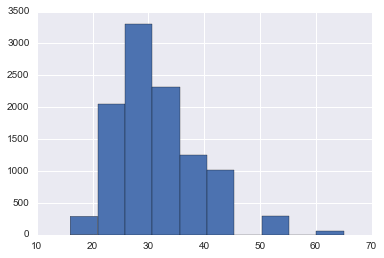

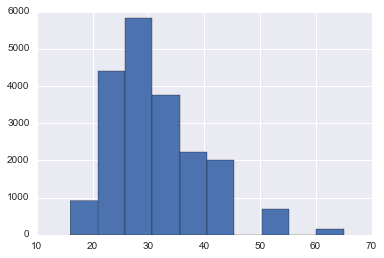

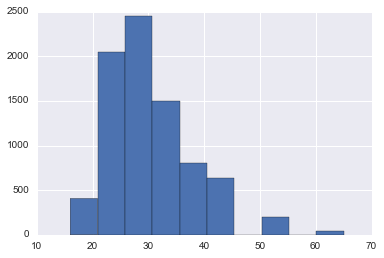

desktop_os with age_midpoint
p=0.0000


In [37]:
test_median(data, 'desktop_os', 'age_midpoint', plots=True)

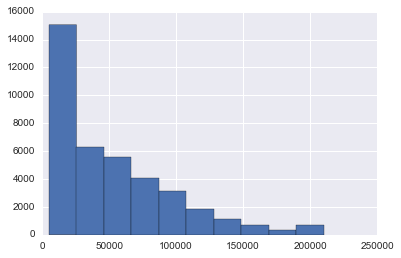

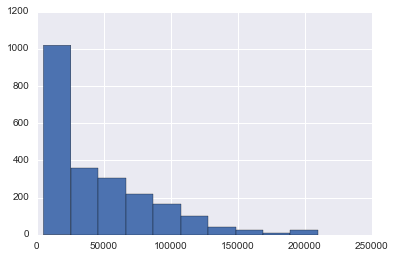

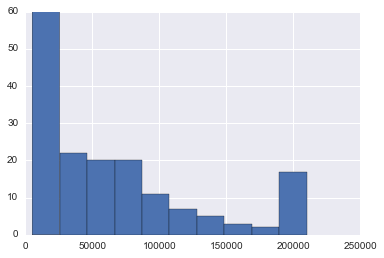

gender with salary_midpoint
p=0.0000


In [38]:
test_median(data, 'gender', 'salary_midpoint', normal=False, plots=True)

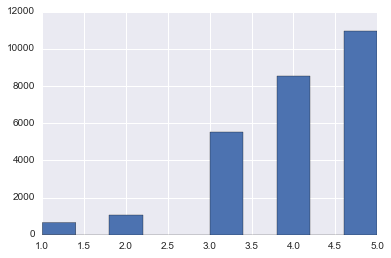

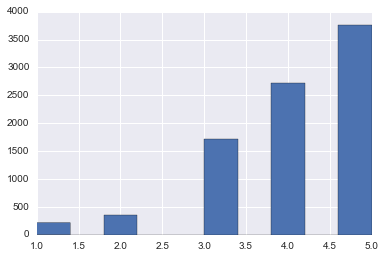

is_python with agree_diversity
p=0.0030


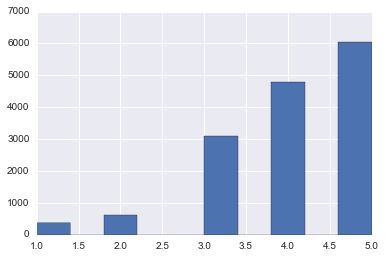

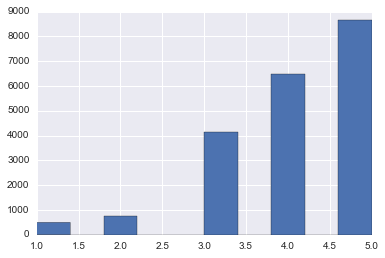

is_javascript with agree_diversity
p=0.0009


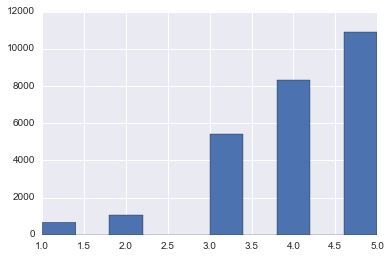

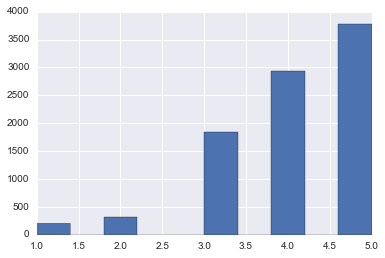

is_php with agree_diversity
p=0.1297


In [39]:
test_median(data, 'is_python', 'agree_diversity', normal=False, plots=True)
test_median(data, 'is_javascript', 'agree_diversity', normal=False, plots=True)
test_median(data, 'is_php', 'agree_diversity', normal=False, plots=True)

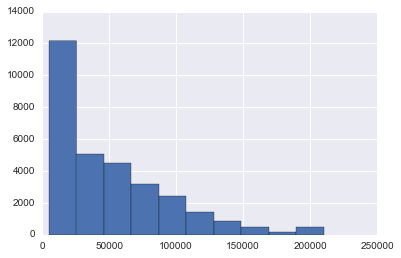

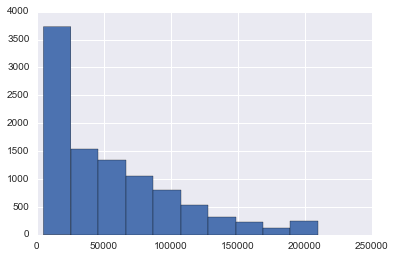

is_python with salary_midpoint
p=0.0000


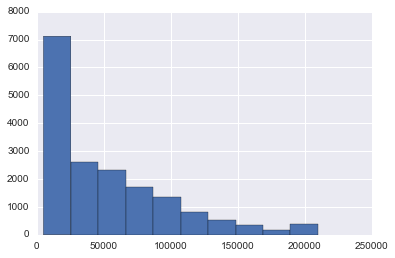

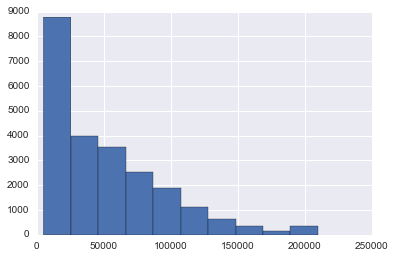

is_javascript with salary_midpoint
p=0.0002


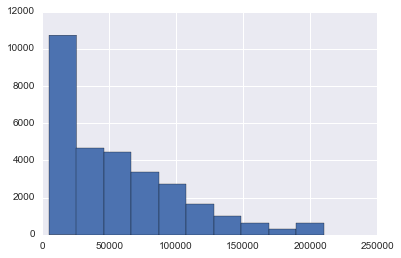

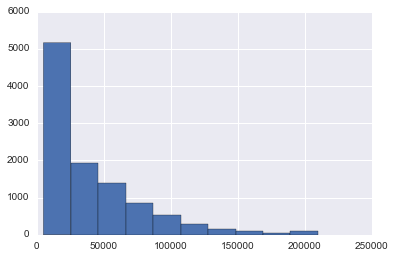

is_php with salary_midpoint
p=0.0000


In [40]:
test_median(data, 'is_python', 'salary_midpoint', normal=False, plots=True)
test_median(data, 'is_javascript', 'salary_midpoint', normal=False, plots=True)
test_median(data, 'is_php', 'salary_midpoint', normal=False, plots=True)

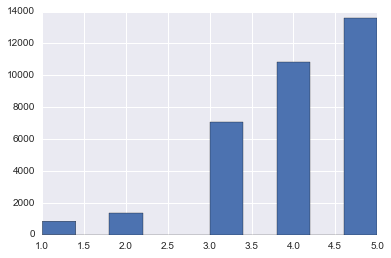

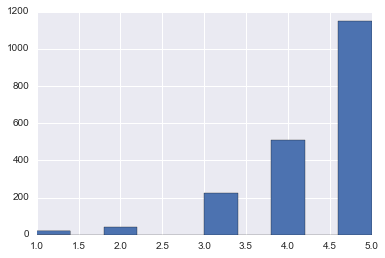

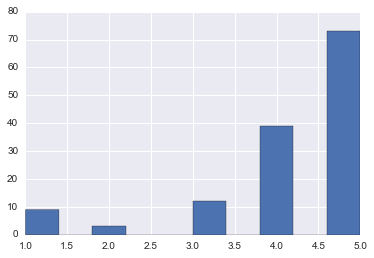

gender with agree_diversity
p=0.0000


In [41]:
test_median(data, 'gender', 'agree_diversity', normal=False, plots=True)

In [39]:
def chisquare(data, x, y):
    d = data.dropna(subset=[x, y])
    population_counts = d[y].value_counts()
    for value in d[x].unique():
        subgroup_counts = d[y][d[x] == value].value_counts()
        # Make sure all possible values are represented                
        for possible_value in population_counts.index:
            if possible_value not in subgroup_counts:
                subgroup_counts[possible_value] = 0
        chisq, p = stats.chisquare(subgroup_counts, population_counts)
        print(subgroup_counts / subgroup_counts.sum())
        print('{}={}: p={}'.format(x, value, p))

In [40]:
chisquare(data, 'is_python', 'desktop_os')
chisquare(data, 'is_javascript', 'desktop_os')
chisquare(data, 'is_php', 'desktop_os')
print(data['desktop_os'].value_counts(normalize=True))

Windows     0.571399
Mac OS X    0.267413
Linux       0.161188
Name: desktop_os, dtype: float64
is_python=False: p=0.0
Linux       0.359141
Windows     0.342976
Mac OS X    0.297884
Name: desktop_os, dtype: float64
is_python=True: p=0.0
Windows     0.507911
Mac OS X    0.255002
Linux       0.237087
Name: desktop_os, dtype: float64
is_javascript=False: p=0.0
Windows     0.520847
Mac OS X    0.289511
Linux       0.189642
Name: desktop_os, dtype: float64
is_javascript=True: p=0.0
Windows     0.532785
Mac OS X    0.268256
Linux       0.198959
Name: desktop_os, dtype: float64
is_php=False: p=0.0
Windows     0.465264
Mac OS X    0.293963
Linux       0.240773
Name: desktop_os, dtype: float64
is_php=True: p=0.0
Windows     0.516879
Mac OS X    0.273731
Linux       0.209389
Name: desktop_os, dtype: float64


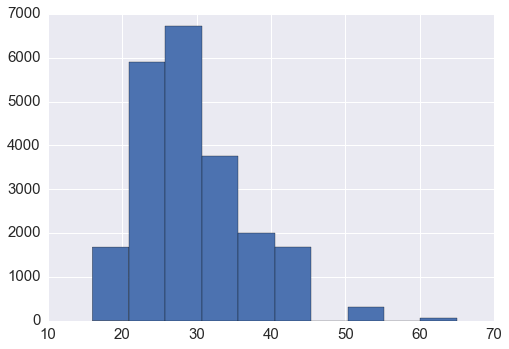

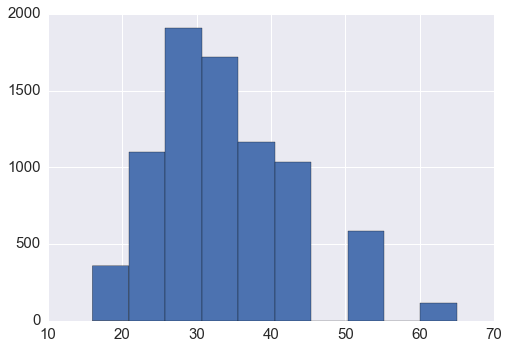

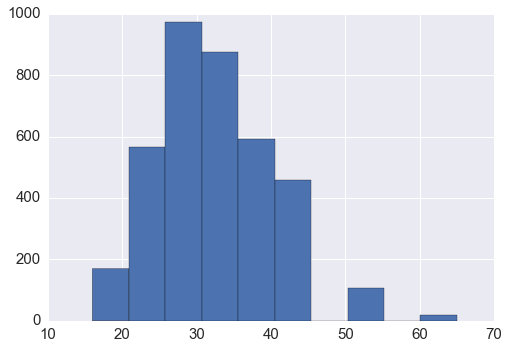

star_wars_vs_star_trek with age_midpoint
p=0.0000


In [18]:
test_median(data, 'star_wars_vs_star_trek', 'age_midpoint', plots=True)

In [43]:
chisquare(data, 'desktop_os', 'un_subregion')
print(data.un_subregion.value_counts(normalize=True))

North America                0.387149
Northern Europe              0.167331
Western Europe               0.133922
Eastern Europe               0.076500
Southern Europe              0.057327
Southern Asia                0.045558
South America                0.030562
Australia and New Zealand    0.028759
Western Asia                 0.018223
Eastern Asia                 0.015661
South-Eastern Asia           0.013003
Central America              0.011864
Southern Africa              0.007118
Caribbean                    0.002088
Northern Africa              0.001708
Western Africa               0.001424
Central Asia                 0.000949
Eastern Africa               0.000664
Melanesia                    0.000095
Middle Africa                0.000095
Name: un_subregion, dtype: float64
desktop_os=Mac OS X: p=0.0
North America                0.230970
Western Europe               0.171212
Eastern Europe               0.134391
Northern Europe              0.127697
Southern Asia             